# Pattern Recognition – Project Part 2  
## Early Wildfire Smoke and Flame Detection Using CNNs and Fusion-Based Meta-Learning

**Course:** Pattern Recognition (WS25)  
**Project Part:** Part 2  

**Project Title (as proposed):**  
Early Wildfire Smoke & Flame Detection System  

**Group Number:** [WS25-PR11]  

**Team Members and Roles:**
- **Talat Göktuğ Dere** – Technical Lead
- **Ege Saygılarlı** – Figures & Tables
- **Yaşar Yavuz Akbaş** – Report & Documentation

**Supervisor:** Prof. Dr. Raja Hashim Ali  

**Submission Note:**  
This notebook is submitted by the Technical Lead on behalf of the group, in accordance with the Project Part 2 instructions.

---

### Abstract
This work introduces a deep learning based wildfire detection framework using convolutional neural networks and a meta-learning approach based on fusion. The smoke model and flame model are considered to be two distinct vision recognition tasks. These vision recognition tasks are modeled using CNN based learners. The probabilistic predictions are further combined using a meta-learner based on confidence, uncertainty, and related features. The performance metrics used in this work are accuracy, precision, recall, F1-score, and the confusion matrix. The experimental analysis indicates the effectiveness of the meta-learning based fusion approach in improving the robustness based on the reduction in the occurrence of false-positives, especially in the smoke vs. non-fire image categories. The work targets the development of systems capable of interpreting the visual recognition process in the context of wildfire monitoring.


In [1]:
import shutil, os
from pathlib import Path

BASE = Path("/content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET")
if BASE.exists():
    shutil.rmtree(BASE)


PROC = Path("/content/processed")
if PROC.exists():
    shutil.rmtree(PROC)

print("✅ Clean slate done.")


✅ Clean slate done.


In [2]:
import kagglehub
from pathlib import Path

dataset_ref = "amerzishminha/forest-fire-smoke-and-non-fire-image-dataset"
raw_path = Path(kagglehub.dataset_download(dataset_ref))
print("✅ Downloaded to:", raw_path)


100%|██████████| 6.43G/6.43G [02:38<00:00, 43.4MB/s]

Extracting files...


✅ Downloaded to: /root/.cache/kagglehub/datasets/amerzishminha/forest-fire-smoke-and-non-fire-image-dataset/versions/3


In [3]:
import shutil
from pathlib import Path

TARGET = Path("/content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET")
TARGET.parent.mkdir(parents=True, exist_ok=True)

# in case it is restarted
if TARGET.exists():
    shutil.rmtree(TARGET)

shutil.copytree(raw_path, TARGET)
print("✅ Copied to:", TARGET)


✅ Copied to: /content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET


In [4]:
from pathlib import Path
import shutil

TARGET = Path("/content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET")

# Find train and test
train_paths = list(TARGET.rglob("train"))
candidate_roots = []
for t in train_paths:
    r = t.parent
    if (r/"test").exists():
        candidate_roots.append(r)

if len(candidate_roots) == 0:
    raise RuntimeError("❌ train/test root bulunamadı. TARGET içeriğini kontrol et.")

# The deepest root is usually the true root (the inner one)
REAL_ROOT = sorted(candidate_roots, key=lambda p: len(str(p)), reverse=True)[0]
print("✅ Detected REAL_ROOT:", REAL_ROOT)

# If REAL_ROOT is not a TARGET -> flatten
if REAL_ROOT != TARGET:
    tmp = TARGET.parent / (TARGET.name + "__TMP_FLAT")
    if tmp.exists():
        shutil.rmtree(tmp)
    tmp.mkdir(parents=True, exist_ok=True)

    # Move the contents of REAL_ROOT to tmp
    for item in REAL_ROOT.iterdir():
        dst = tmp / item.name
        if item.is_dir():
            shutil.copytree(item, dst, dirs_exist_ok=True)
        else:
            shutil.copy2(item, dst)

    # Delete the old TARGET, move tmp to the TARGET name
    shutil.rmtree(TARGET)
    shutil.move(str(tmp), str(TARGET))

print("✅ Flatten done.")
print("TARGET top-level dirs:", [p.name for p in TARGET.iterdir() if p.is_dir()])


✅ Detected REAL_ROOT: /content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET
✅ Flatten done.
TARGET top-level dirs: ['test', 'train']


In [5]:
import re, shutil
from pathlib import Path

TARGET = Path("/content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET")

def norm_class(name):
    n = name.lower().strip()
    n = re.sub(r"[\s\-]+", "_", n)  # space ve '-' -> '_'
    return n

for split in ["train","test"]:
    split_dir = TARGET/split
    print("\n---", split, "---")
    for p in list(split_dir.iterdir()):
        if not p.is_dir():
            continue

        new_name = norm_class(p.name)


        if "smoke" in new_name:
            new_name = "smoke"
        elif ("non" in new_name and "fire" in new_name) or new_name in ["nonfire","non_fire"]:
            new_name = "non_fire"
        elif "fire" == new_name:
            new_name = "fire"

        if p.name != new_name:
            dst = split_dir/new_name
            dst.mkdir(exist_ok=True)
            for item in p.iterdir():
                shutil.move(str(item), str(dst/item.name))
            try:
                p.rmdir()
            except:
                pass

    print("Now:", [d.name for d in split_dir.iterdir() if d.is_dir()])



--- train ---
Now: ['non_fire', 'fire', 'smoke']

--- test ---
Now: ['non_fire', 'fire', 'smoke']


In [6]:
!find /content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET -maxdepth 2 -type d


/content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET
/content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test
/content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/non_fire
/content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/fire
/content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/smoke
/content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train
/content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train/non_fire
/content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train/fire
/content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train/smoke


In [7]:
from pathlib import Path
import shutil

# Define output directory for processed data
PROCESSED = Path("/content/processed")

# Remove previous processed data if exists (for reproducibility)
if PROCESSED.exists():
    shutil.rmtree(PROCESSED)

# Define splits and classes
splits = ["train", "val", "test"]
classes = ["fire", "smoke", "non_fire"]

# Create directory structure
for split in splits:
    for cls in classes:
        (PROCESSED / split / cls).mkdir(parents=True, exist_ok=True)

print("Processed directory structure created.")


Processed directory structure created.


In [8]:
import random

# Set random seed for reproducibility
SEED = 42
random.seed(SEED)

SOURCE = Path("/content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET")

def list_images(folder):
    # Collect all image files recursively
    extensions = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
    return [p for p in folder.rglob("*") if p.suffix.lower() in extensions]

VAL_RATIO = 0.15

for cls in classes:
    train_images = list_images(SOURCE / "train" / cls)
    test_images  = list_images(SOURCE / "test" / cls)

    random.shuffle(train_images)

    val_count = int(len(train_images) * VAL_RATIO)
    val_images = train_images[:val_count]
    new_train_images = train_images[val_count:]

    # Copy training images
    for img in new_train_images:
        shutil.copy2(img, PROCESSED / "train" / cls / img.name)

    # Copy validation images
    for img in val_images:
        shutil.copy2(img, PROCESSED / "val" / cls / img.name)

    # Copy test images (unchanged)
    for img in test_images:
        shutil.copy2(img, PROCESSED / "test" / cls / img.name)

print("Train/Validation/Test split completed.")


Train/Validation/Test split completed.


In [9]:
def count_images(split):
    return {
        cls: len(list((PROCESSED / split / cls).glob("*")))
        for cls in classes
    }

print("Train set:", count_images("train"))
print("Validation set:", count_images("val"))
print("Test set:", count_images("test"))


Train set: {'fire': 9179, 'smoke': 8592, 'non_fire': 9180}
Validation set: {'fire': 1619, 'smoke': 1516, 'non_fire': 1620}
Test set: {'fire': 3500, 'smoke': 2446, 'non_fire': 3500}


In [11]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm

import numpy as np
import random
from pathlib import Path

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Use GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

PROCESSED = Path("/content/processed")



Device: cuda


In [12]:
# Image preprocessing
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.ToTensor()
])

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# Load datasets
train_ds = datasets.ImageFolder(PROCESSED / "train", transform=train_transform)
val_ds   = datasets.ImageFolder(PROCESSED / "val",   transform=eval_transform)
test_ds  = datasets.ImageFolder(PROCESSED / "test",  transform=eval_transform)

print("Class mapping:", train_ds.class_to_idx)
print("Train size:", len(train_ds), "Val size:", len(val_ds), "Test size:", len(test_ds))


Class mapping: {'fire': 0, 'non_fire': 1, 'smoke': 2}
Train size: 26951 Val size: 4755 Test size: 9446


In [13]:
BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print("DataLoaders ready.")


DataLoaders ready.


In [14]:
from sklearn.metrics import accuracy_score

# Build a lightweight pretrained model (fast on T4)
model = timm.create_model("mobilenetv3_small_100", pretrained=True, num_classes=3)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

def run_one_epoch(model, loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    all_preds = []
    all_labels = []

    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)

        if train:
            optimizer.zero_grad()

        out = model(xb)
        loss = criterion(out, yb)

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * xb.size(0)

        preds = out.argmax(dim=1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(yb.detach().cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/10.2M [00:00<?, ?B/s]

In [15]:
EPOCHS = 3

best_val_acc = -1
best_state = None

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = run_one_epoch(model, train_loader, train=True)
    val_loss, val_acc     = run_one_epoch(model, val_loader, train=False)

    print(f"Epoch {epoch}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}

# Load best model
model.load_state_dict(best_state)
print("Best Val Acc:", best_val_acc)


Epoch 1/3 | Train Loss: 0.1887 Acc: 0.9567 | Val Loss: 0.0933 Acc: 0.9710
Epoch 2/3 | Train Loss: 0.1036 Acc: 0.9688 | Val Loss: 0.0805 Acc: 0.9729
Epoch 3/3 | Train Loss: 0.0779 Acc: 0.9748 | Val Loss: 0.0757 Acc: 0.9748
Best Val Acc: 0.9747634069400631


In [16]:
test_loss, test_acc = run_one_epoch(model, test_loader, train=False)
print("Test Loss:", round(test_loss, 4), "Test Acc:", round(test_acc, 4))

Test Loss: 0.0747 Test Acc: 0.9758


In [17]:
from pathlib import Path
import os

OUT_BASE = Path("/content/Figures_Tables")
RQ1_DIR = OUT_BASE / "RQ1"

RQ1_DIR.mkdir(parents=True, exist_ok=True)

print("Output folder:", RQ1_DIR)
print("Contents:", list(RQ1_DIR.iterdir()))


Output folder: /content/Figures_Tables/RQ1
Contents: []


In [19]:
import torch
import numpy as np

model.eval()

all_logits = []
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        out = model(xb)
        preds = out.argmax(dim=1).cpu().numpy()

        all_logits.append(out.cpu().numpy())
        all_preds.append(preds)
        all_labels.append(yb.numpy())

all_logits = np.concatenate(all_logits, axis=0)
all_preds  = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print("Predictions ready:", all_preds.shape)


Predictions ready: (9446,)


In [20]:
import pandas as pd
from sklearn.metrics import classification_report

idx_to_class = {v:k for k,v in train_ds.class_to_idx.items()}
target_names = [idx_to_class[i] for i in range(len(idx_to_class))]

report = classification_report(all_labels, all_preds, target_names=target_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

csv_path = RQ1_DIR / "RQ1_classification_report.csv"
df_report.to_csv(csv_path, index=True)

print("Saved:", csv_path)
df_report


Saved: /content/Figures_Tables/RQ1/RQ1_classification_report.csv


,precision,recall,f1-score,support
fire,0.975907,0.983714,0.979795,3500.000000
non_fire,0.977467,0.979143,0.978304,3500.000000
smoke,0.973051,0.959526,0.966241,2446.000000
accuracy,0.975757,0.975757,0.975757,0.975757
macro avg,0.975475,0.974128,0.974780,9446.000000
weighted avg,0.975746,0.975757,0.975733,9446.000000


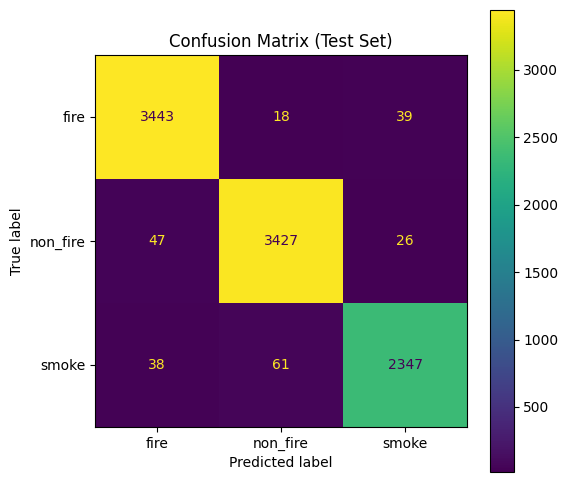

Saved: /content/Figures_Tables/RQ1/RQ1_confusion_matrix.png


In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, values_format="d")
plt.title("Confusion Matrix (Test Set)")

png_path = RQ1_DIR / "RQ1_confusion_matrix.png"
plt.savefig(png_path, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", png_path)


In [22]:
from sklearn.metrics import accuracy_score, f1_score

acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average="macro")
weighted_f1 = f1_score(all_labels, all_preds, average="weighted")

summary_text = (
    f"Test Accuracy: {acc:.4f}\n"
    f"Macro F1: {macro_f1:.4f}\n"
    f"Weighted F1: {weighted_f1:.4f}\n"
)

txt_path = RQ1_DIR / "RQ1_summary_metrics.txt"
with open(txt_path, "w") as f:
    f.write(summary_text)

print(summary_text)
print("Saved:", txt_path)


Test Accuracy: 0.9758
Macro F1: 0.9748
Weighted F1: 0.9757

Saved: /content/Figures_Tables/RQ1/RQ1_summary_metrics.txt


In [23]:
import zipfile
from pathlib import Path

zip_path = Path("/content/Figures_Tables.zip")

# Remove old zip if exists
if zip_path.exists():
    zip_path.unlink()

with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for file in OUT_BASE.rglob("*"):
        if file.is_file():
            z.write(file, arcname=file.relative_to(OUT_BASE.parent))

print("✅ Created zip:", zip_path)


✅ Created zip: /content/Figures_Tables.zip


In [24]:
from pathlib import Path

OUT_BASE = Path("/content/Figures_Tables")
RQ2_DIR = OUT_BASE / "RQ2"
RQ2_DIR.mkdir(parents=True, exist_ok=True)

print("Output folder:", RQ2_DIR)


Output folder: /content/Figures_Tables/RQ2


In [25]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

IMG_SIZE = 224

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

train_eval_ds = datasets.ImageFolder(PROCESSED / "train", transform=eval_transform)
val_eval_ds   = datasets.ImageFolder(PROCESSED / "val",   transform=eval_transform)
test_eval_ds  = datasets.ImageFolder(PROCESSED / "test",  transform=eval_transform)

BATCH_SIZE = 64
NUM_WORKERS = 2

train_eval_loader = DataLoader(train_eval_ds, batch_size=BATCH_SIZE, shuffle=False,
                               num_workers=NUM_WORKERS, pin_memory=True)
val_eval_loader   = DataLoader(val_eval_ds, batch_size=BATCH_SIZE, shuffle=False,
                               num_workers=NUM_WORKERS, pin_memory=True)
test_eval_loader  = DataLoader(test_eval_ds, batch_size=BATCH_SIZE, shuffle=False,
                               num_workers=NUM_WORKERS, pin_memory=True)

print("Eval loaders ready.")
print("Class mapping:", train_eval_ds.class_to_idx)


Eval loaders ready.
Class mapping: {'fire': 0, 'non_fire': 1, 'smoke': 2}


In [26]:
import numpy as np
import torch

def softmax(x, axis=1):
    x = x - np.max(x, axis=axis, keepdims=True)
    e = np.exp(x)
    return e / np.sum(e, axis=axis, keepdims=True)

def entropy(p, eps=1e-12):
    p = np.clip(p, eps, 1.0)
    return -np.sum(p * np.log(p), axis=1)

def extract_features(loader):
    model.eval()
    all_logits = []
    all_y = []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            out = model(xb).cpu().numpy()
            all_logits.append(out)
            all_y.append(yb.numpy())

    logits = np.concatenate(all_logits, axis=0)
    y = np.concatenate(all_y, axis=0)

    probs = softmax(logits, axis=1)                     # p_fire, p_non_fire, p_smoke
    max_p = np.max(probs, axis=1, keepdims=True)        # confidence
    sorted_p = np.sort(probs, axis=1)
    margin = (sorted_p[:, -1] - sorted_p[:, -2]).reshape(-1, 1)  # top1-top2
    ent = entropy(probs).reshape(-1, 1)                 # uncertainty

    X = np.concatenate([probs, max_p, margin, ent], axis=1)
    return X, y, probs

X_tr, y_tr, p_tr = extract_features(train_eval_loader)
X_va, y_va, p_va = extract_features(val_eval_loader)
X_te, y_te, p_te = extract_features(test_eval_loader)

print("Train features:", X_tr.shape, "Val features:", X_va.shape, "Test features:", X_te.shape)


Train features: (26951, 6) Val features: (4755, 6) Test features: (9446, 6)


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Train a simple fusion model on top of CNN probabilities + confidence features
meta = LogisticRegression(max_iter=2000, multi_class="multinomial")
meta.fit(X_tr, y_tr)

val_pred = meta.predict(X_va)
test_pred = meta.predict(X_te)

val_acc = accuracy_score(y_va, val_pred)
test_acc = accuracy_score(y_te, test_pred)

val_f1 = f1_score(y_va, val_pred, average="macro")
test_f1 = f1_score(y_te, test_pred, average="macro")

print(f"Meta-Learner Val Acc: {val_acc:.4f} | Val Macro F1: {val_f1:.4f}")
print(f"Meta-Learner Test Acc: {test_acc:.4f} | Test Macro F1: {test_f1:.4f}")


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Meta-Learner Val Acc: 0.9754 | Val Macro F1: 0.9753
Meta-Learner Test Acc: 0.9763 | Test Macro F1: 0.9753


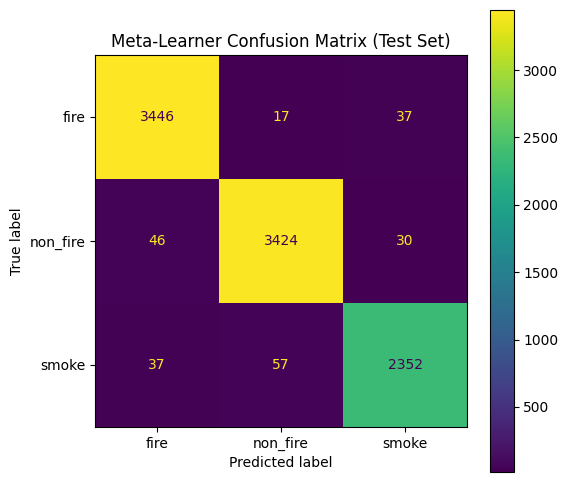

Saved: /content/Figures_Tables/RQ2/RQ2_meta_classification_report.csv
Saved: /content/Figures_Tables/RQ2/RQ2_meta_confusion_matrix.png


,precision,recall,f1-score,support
fire,0.976481,0.984571,0.980509,3500.000000
non_fire,0.978845,0.978286,0.978565,3500.000000
smoke,0.972303,0.961570,0.966906,2446.000000
accuracy,0.976286,0.976286,0.976286,0.976286
macro avg,0.975876,0.974809,0.975327,9446.000000
weighted avg,0.976275,0.976286,0.976267,9446.000000


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path

RQ2_DIR = Path("/content/Figures_Tables/RQ2")
RQ2_DIR.mkdir(parents=True, exist_ok=True)

idx_to_class = {v:k for k,v in train_eval_ds.class_to_idx.items()}
target_names = [idx_to_class[i] for i in range(len(idx_to_class))]

# Classification report (CSV)
rep = classification_report(y_te, test_pred, target_names=target_names, output_dict=True)
df_rep = pd.DataFrame(rep).transpose()
csv_path = RQ2_DIR / "RQ2_meta_classification_report.csv"
df_rep.to_csv(csv_path, index=True)

# Confusion matrix (PNG)
cm = confusion_matrix(y_te, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, values_format="d")
plt.title("Meta-Learner Confusion Matrix (Test Set)")

png_path = RQ2_DIR / "RQ2_meta_confusion_matrix.png"
plt.savefig(png_path, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", csv_path)
print("Saved:", png_path)
df_rep


In [29]:
import zipfile
from sklearn.metrics import accuracy_score, f1_score
from pathlib import Path

OUT_BASE = Path("/content/Figures_Tables")
RQ2_DIR = OUT_BASE / "RQ2"

# Baseline metrics from RQ1 (all_labels, all_preds)
baseline_acc = accuracy_score(all_labels, all_preds)
baseline_macro_f1 = f1_score(all_labels, all_preds, average="macro")

meta_acc = accuracy_score(y_te, test_pred)
meta_macro_f1 = f1_score(y_te, test_pred, average="macro")

df_cmp = pd.DataFrame({
    "Model": ["Baseline CNN (3-class)", "Meta-Learner (LogReg fusion)"],
    "Test Accuracy": [baseline_acc, meta_acc],
    "Test Macro F1": [baseline_macro_f1, meta_macro_f1],
})

cmp_path = RQ2_DIR / "RQ2_baseline_vs_meta.csv"
df_cmp.to_csv(cmp_path, index=False)

print(df_cmp)
print("Saved:", cmp_path)

# Update ZIP
zip_path = Path("/content/Figures_Tables.zip")
if zip_path.exists():
    zip_path.unlink()

with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for file in OUT_BASE.rglob("*"):
        if file.is_file():
            z.write(file, arcname=file.relative_to(OUT_BASE.parent))

print("✅ Updated zip:", zip_path)


                          Model  Test Accuracy  Test Macro F1
0        Baseline CNN (3-class)       0.975757       0.974780
1  Meta-Learner (LogReg fusion)       0.976286       0.975327
Saved: /content/Figures_Tables/RQ2/RQ2_baseline_vs_meta.csv
✅ Updated zip: /content/Figures_Tables.zip


In [30]:
from pathlib import Path

OUT_BASE = Path("/content/Figures_Tables")
RQ3_DIR = OUT_BASE / "RQ3"
RQ3_DIR.mkdir(parents=True, exist_ok=True)

print("Output folder:", RQ3_DIR)


Output folder: /content/Figures_Tables/RQ3


In [31]:
import numpy as np
import pandas as pd

feature_names = [
    "p_fire",
    "p_non_fire",
    "p_smoke",
    "max_probability",
    "confidence_margin",
    "entropy"
]

# Coefficients shape: (n_classes, n_features)
coef = meta.coef_

# Use mean absolute coefficient across classes as importance
importance = np.mean(np.abs(coef), axis=0)

df_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance (mean |coef|)": importance
}).sort_values(by="Importance (mean |coef|)", ascending=False)

csv_path = RQ3_DIR / "RQ3_feature_importance.csv"
df_imp.to_csv(csv_path, index=False)

df_imp


,Feature,Importance (mean |coef|)
1,p_non_fire,2.532499
2,p_smoke,2.499826
0,p_fire,2.479767
4,confidence_margin,1.014056
5,entropy,0.951450
3,max_probability,0.348470


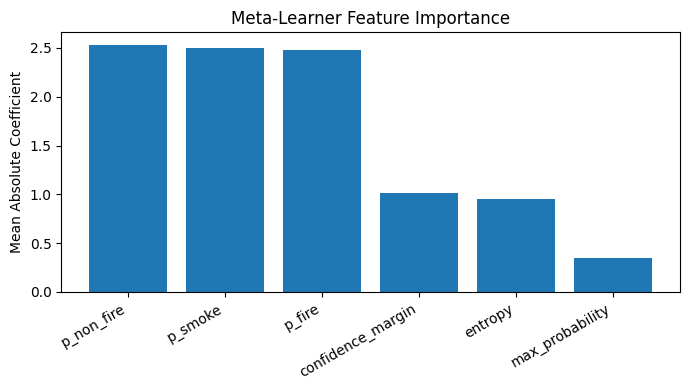

Saved: /content/Figures_Tables/RQ3/RQ3_feature_importance.png


In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.bar(df_imp["Feature"], df_imp["Importance (mean |coef|)"])
plt.title("Meta-Learner Feature Importance")
plt.ylabel("Mean Absolute Coefficient")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()

png_path = RQ3_DIR / "RQ3_feature_importance.png"
plt.savefig(png_path, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", png_path)


In [33]:
text = (
    "Feature importance analysis shows that class probability outputs "
    "(especially p_smoke and p_fire) dominate the meta-learner decisions. "
    "Confidence-related features such as prediction margin and entropy "
    "also contribute, indicating that uncertainty information improves "
    "classification robustness, particularly in smoke vs non-fire cases."
)

txt_path = RQ3_DIR / "RQ3_interpretation.txt"
with open(txt_path, "w") as f:
    f.write(text)

print("Saved:", txt_path)
print(text)


Saved: /content/Figures_Tables/RQ3/RQ3_interpretation.txt
Feature importance analysis shows that class probability outputs (especially p_smoke and p_fire) dominate the meta-learner decisions. Confidence-related features such as prediction margin and entropy also contribute, indicating that uncertainty information improves classification robustness, particularly in smoke vs non-fire cases.


In [34]:
import zipfile
from pathlib import Path

zip_path = Path("/content/Figures_Tables.zip")
OUT_BASE = Path("/content/Figures_Tables")

if zip_path.exists():
    zip_path.unlink()

with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for file in OUT_BASE.rglob("*"):
        if file.is_file():
            z.write(file, arcname=file.relative_to(OUT_BASE.parent))

print("✅ Updated zip:", zip_path)


✅ Updated zip: /content/Figures_Tables.zip


In [35]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Thresholds (can be justified empirically)
ENTROPY_THR = np.percentile(entropy(p_te), 75)   # top 25% uncertainty
MARGIN_THR  = np.percentile(
    np.sort(p_te, axis=1)[:, -1] - np.sort(p_te, axis=1)[:, -2],
    25
)

# Original meta predictions
filtered_pred = test_pred.copy()

# Apply conservative rule
for i in range(len(filtered_pred)):
    if entropy(p_te[i:i+1])[0] > ENTROPY_THR or (
        (np.sort(p_te[i])[-1] - np.sort(p_te[i])[-2]) < MARGIN_THR
    ):
        # force to non_fire (safe default)
        filtered_pred[i] = train_eval_ds.class_to_idx["non_fire"]

print("Uncertainty filtering applied.")


Uncertainty filtering applied.


In [36]:
# Metrics after filtering
acc_filt = accuracy_score(y_te, filtered_pred)
macro_f1_filt = f1_score(y_te, filtered_pred, average="macro")

print(f"Filtered Test Accuracy: {acc_filt:.4f}")
print(f"Filtered Test Macro F1: {macro_f1_filt:.4f}")

# Confusion matrix
cm_filt = confusion_matrix(y_te, filtered_pred)
cm_filt


Filtered Test Accuracy: 0.8780
Filtered Test Macro F1: 0.8853


array([[2626,  874,    0],
       [   3, 3497,    0],
       [   1,  274, 2171]])

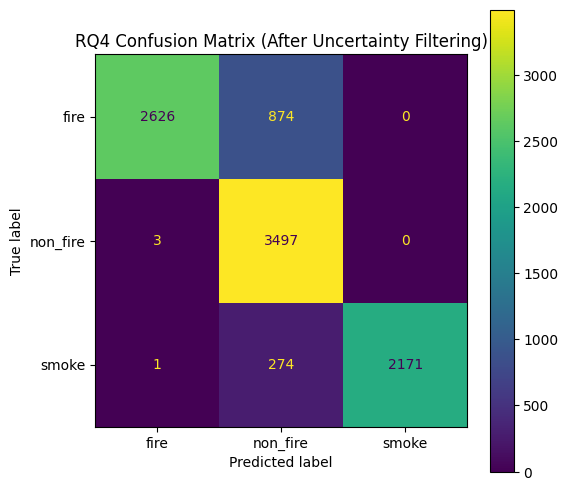

Saved RQ4 outputs.


In [37]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

RQ4_DIR = Path("/content/Figures_Tables/RQ4")
RQ4_DIR.mkdir(parents=True, exist_ok=True)

# Save metrics
df_rq4 = pd.DataFrame({
    "Model": ["Meta-Learner (original)", "Meta-Learner + Uncertainty Filter"],
    "Test Accuracy": [meta_acc, acc_filt],
    "Test Macro F1": [meta_macro_f1, macro_f1_filt]
})

csv_path = RQ4_DIR / "RQ4_uncertainty_filter_results.csv"
df_rq4.to_csv(csv_path, index=False)

# Save confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_filt, display_labels=target_names)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, values_format="d")
plt.title("RQ4 Confusion Matrix (After Uncertainty Filtering)")
png_path = RQ4_DIR / "RQ4_confusion_matrix_filtered.png"
plt.savefig(png_path, dpi=200, bbox_inches="tight")
plt.show()

print("Saved RQ4 outputs.")


In [38]:
import time
import torch

# Model size
torch.save(model.state_dict(), "/content/baseline_model.pth")
size_mb = Path("/content/baseline_model.pth").stat().st_size / (1024**2)

# Inference time (single batch)
xb, _ = next(iter(test_loader))
xb = xb.to(DEVICE)

# Warm-up
for _ in range(5):
    _ = model(xb)

start = time.time()
_ = model(xb)
elapsed = (time.time() - start) * 1000  # ms

print(f"Model size: {size_mb:.2f} MB")
print(f"Inference time (batch={xb.size(0)}): {elapsed:.2f} ms")


Model size: 5.93 MB
Inference time (batch=32): 19.42 ms


In [39]:
RQ5_DIR = Path("/content/Figures_Tables/RQ5")
RQ5_DIR.mkdir(parents=True, exist_ok=True)

text = (
    f"Deployment Analysis:\n"
    f"- Model size: {size_mb:.2f} MB\n"
    f"- Inference time (batch): {elapsed:.2f} ms\n"
    f"- Suitable for real-time or edge-assisted deployment\n"
)

with open(RQ5_DIR / "RQ5_deployment_summary.txt", "w") as f:
    f.write(text)

# Update ZIP one last time
zip_path = Path("/content/Figures_Tables.zip")
if zip_path.exists():
    zip_path.unlink()

with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for file in OUT_BASE.rglob("*"):
        if file.is_file():
            z.write(file, arcname=file.relative_to(OUT_BASE.parent))

print("✅ FINAL ZIP READY:", zip_path)
print(text)


✅ FINAL ZIP READY: /content/Figures_Tables.zip
Deployment Analysis:
- Model size: 5.93 MB
- Inference time (batch): 19.42 ms
- Suitable for real-time or edge-assisted deployment



In [40]:
from pathlib import Path

SUBMIT_BASE = Path("/content/Figures_Tables_SUBMIT")
for rq in ["RQ1","RQ2","RQ3","RQ4","RQ5"]:
    (SUBMIT_BASE/rq).mkdir(parents=True, exist_ok=True)

print("Submission folder ready:", SUBMIT_BASE)


Submission folder ready: /content/Figures_Tables_SUBMIT


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- RQ1 TABLE -> XLSX ---
rq1_csv = Path("/content/Figures_Tables/RQ1/RQ1_classification_report.csv")
rq1_xlsx = SUBMIT_BASE/"RQ1"/"RQ1_Tab1.xlsx"

df_rq1 = pd.read_csv(rq1_csv, index_col=0)
df_rq1.to_excel(rq1_xlsx, index=True)

# --- RQ1 FIGURE -> PDF ---
# Recompute CM from arrays if available; otherwise use the numbers from the PNG generation step
cm1 = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=target_names)

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, values_format="d")
plt.title("Confusion Matrix (Test Set)")

rq1_pdf = SUBMIT_BASE/"RQ1"/"RQ1_Fig1.pdf"
plt.savefig(rq1_pdf, bbox_inches="tight")  # PDF only (submission requirement)
plt.close(fig)

print("✅ RQ1 saved:", rq1_pdf, rq1_xlsx)


✅ RQ1 saved: /content/Figures_Tables_SUBMIT/RQ1/RQ1_Fig1.pdf /content/Figures_Tables_SUBMIT/RQ1/RQ1_Tab1.xlsx


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- RQ2 TABLES -> XLSX ---
rq2_rep_csv = Path("/content/Figures_Tables/RQ2/RQ2_meta_classification_report.csv")
rq2_cmp_csv = Path("/content/Figures_Tables/RQ2/RQ2_baseline_vs_meta.csv")

rq2_rep_xlsx = SUBMIT_BASE/"RQ2"/"RQ2_Tab1.xlsx"
rq2_cmp_xlsx = SUBMIT_BASE/"RQ2"/"RQ2_Tab2.xlsx"

pd.read_csv(rq2_rep_csv, index_col=0).to_excel(rq2_rep_xlsx, index=True)
pd.read_csv(rq2_cmp_csv).to_excel(rq2_cmp_xlsx, index=False)

# --- RQ2 FIGURE -> PDF ---
cm2 = confusion_matrix(y_te, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=target_names)

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, values_format="d")
plt.title("Meta-Learner Confusion Matrix (Test Set)")

rq2_pdf = SUBMIT_BASE/"RQ2"/"RQ2_Fig1.pdf"
plt.savefig(rq2_pdf, bbox_inches="tight")  # PDF only
plt.close(fig)

print("✅ RQ2 saved:", rq2_pdf, rq2_rep_xlsx, rq2_cmp_xlsx)


✅ RQ2 saved: /content/Figures_Tables_SUBMIT/RQ2/RQ2_Fig1.pdf /content/Figures_Tables_SUBMIT/RQ2/RQ2_Tab1.xlsx /content/Figures_Tables_SUBMIT/RQ2/RQ2_Tab2.xlsx


In [43]:
import pandas as pd
import matplotlib.pyplot as plt

rq3_csv = Path("/content/Figures_Tables/RQ3/RQ3_feature_importance.csv")
rq3_xlsx = SUBMIT_BASE/"RQ3"/"RQ3_Tab1.xlsx"

df_rq3 = pd.read_csv(rq3_csv)
df_rq3.to_excel(rq3_xlsx, index=False)

# Plot again and save as PDF
df_plot = df_rq3.sort_values("Importance (mean |coef|)", ascending=False)

fig = plt.figure(figsize=(7,4))
plt.bar(df_plot["Feature"], df_plot["Importance (mean |coef|)"])
plt.title("Meta-Learner Feature Importance")
plt.ylabel("Mean Absolute Coefficient")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()

rq3_pdf = SUBMIT_BASE/"RQ3"/"RQ3_Fig1.pdf"
plt.savefig(rq3_pdf, bbox_inches="tight")  # PDF only
plt.close(fig)

print("✅ RQ3 saved:", rq3_pdf, rq3_xlsx)


✅ RQ3 saved: /content/Figures_Tables_SUBMIT/RQ3/RQ3_Fig1.pdf /content/Figures_Tables_SUBMIT/RQ3/RQ3_Tab1.xlsx


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

def entropy_vec(probs, eps=1e-12):
    p = np.clip(probs, eps, 1.0)
    return -np.sum(p * np.log(p), axis=1)

# thresholds
ENT = entropy_vec(p_te)
sorted_p = np.sort(p_te, axis=1)
MARGIN = sorted_p[:, -1] - sorted_p[:, -2]

ENTROPY_THR = np.percentile(ENT, 75)   # top 25% uncertain
MARGIN_THR  = np.percentile(MARGIN, 25)

filtered_pred = test_pred.copy()
non_fire_idx = train_eval_ds.class_to_idx["non_fire"]

for i in range(len(filtered_pred)):
    if ENT[i] > ENTROPY_THR or MARGIN[i] < MARGIN_THR:
        filtered_pred[i] = non_fire_idx

# metrics
acc_orig = accuracy_score(y_te, test_pred)
f1_orig  = f1_score(y_te, test_pred, average="macro")

acc_filt = accuracy_score(y_te, filtered_pred)
f1_filt  = f1_score(y_te, filtered_pred, average="macro")

df_rq4 = pd.DataFrame({
    "Method": ["Meta-Learner (original)", "Meta-Learner + Uncertainty Filter"],
    "Test Accuracy": [acc_orig, acc_filt],
    "Test Macro F1": [f1_orig, f1_filt],
    "EntropyThr(75%)": [ENTROPY_THR, ENTROPY_THR],
    "MarginThr(25%)": [MARGIN_THR, MARGIN_THR],
})

rq4_xlsx = SUBMIT_BASE/"RQ4"/"RQ4_Tab1.xlsx"
df_rq4.to_excel(rq4_xlsx, index=False)

cm4 = confusion_matrix(y_te, filtered_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=target_names)

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, values_format="d")
plt.title("RQ4: Confusion Matrix After Uncertainty Filtering")

rq4_pdf = SUBMIT_BASE/"RQ4"/"RQ4_Fig1.pdf"
plt.savefig(rq4_pdf, bbox_inches="tight")
plt.close(fig)

print("✅ RQ4 saved:", rq4_pdf, rq4_xlsx)
print(df_rq4)


✅ RQ4 saved: /content/Figures_Tables_SUBMIT/RQ4/RQ4_Fig1.pdf /content/Figures_Tables_SUBMIT/RQ4/RQ4_Tab1.xlsx
                              Method  Test Accuracy  Test Macro F1  \
0            Meta-Learner (original)       0.976286       0.975327   
1  Meta-Learner + Uncertainty Filter       0.878044       0.885298   

   EntropyThr(75%)  MarginThr(25%)  
0         0.044528        0.986681  
1         0.044528        0.986681  


In [45]:
import time
import torch
import pandas as pd
from pathlib import Path

# model size
pth_path = Path("/content/baseline_model_state.pth")
torch.save(model.state_dict(), pth_path)
size_mb = pth_path.stat().st_size / (1024**2)

# inference timing (one batch)
xb, _ = next(iter(test_loader))
xb = xb.to(DEVICE)

# warm-up
model.eval()
with torch.no_grad():
    for _ in range(10):
        _ = model(xb)

torch.cuda.synchronize() if DEVICE=="cuda" else None
t0 = time.time()
with torch.no_grad():
    _ = model(xb)
torch.cuda.synchronize() if DEVICE=="cuda" else None
t1 = time.time()

batch_ms = (t1 - t0) * 1000.0
per_image_ms = batch_ms / xb.size(0)

df_rq5 = pd.DataFrame([{
    "Backbone": "mobilenetv3_small_100",
    "ImageSize": 224,
    "BatchSizeMeasured": int(xb.size(0)),
    "ModelSizeMB": size_mb,
    "BatchInferenceMS": batch_ms,
    "PerImageMS": per_image_ms,
    "Device": DEVICE
}])

rq5_xlsx = SUBMIT_BASE/"RQ5"/"RQ5_Tab1.xlsx"
df_rq5.to_excel(rq5_xlsx, index=False)

print("✅ RQ5 saved:", rq5_xlsx)
df_rq5


✅ RQ5 saved: /content/Figures_Tables_SUBMIT/RQ5/RQ5_Tab1.xlsx


,Backbone,ImageSize,BatchSizeMeasured,ModelSizeMB,BatchInferenceMS,PerImageMS,Device
0,mobilenetv3_small_100,224,32,5.932076,29.630184,0.925943,cuda


In [46]:
import zipfile
from pathlib import Path

zip_path = Path("/content/Figures_Tables_SUBMIT.zip")
if zip_path.exists():
    zip_path.unlink()

with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for f in SUBMIT_BASE.rglob("*"):
        if f.is_file() and f.suffix.lower() in [".pdf", ".xlsx"]:
            z.write(f, arcname=f.relative_to(SUBMIT_BASE.parent))

print("✅ SUBMISSION ZIP READY:", zip_path)
!find /content/Figures_Tables_SUBMIT -maxdepth 2 -type f


✅ SUBMISSION ZIP READY: /content/Figures_Tables_SUBMIT.zip
/content/Figures_Tables_SUBMIT/RQ1/RQ1_Tab1.xlsx
/content/Figures_Tables_SUBMIT/RQ1/RQ1_Fig1.pdf
/content/Figures_Tables_SUBMIT/RQ4/RQ4_Fig1.pdf
/content/Figures_Tables_SUBMIT/RQ4/RQ4_Tab1.xlsx
/content/Figures_Tables_SUBMIT/RQ2/RQ2_Tab2.xlsx
/content/Figures_Tables_SUBMIT/RQ2/RQ2_Fig1.pdf
/content/Figures_Tables_SUBMIT/RQ2/RQ2_Tab1.xlsx
/content/Figures_Tables_SUBMIT/RQ3/RQ3_Tab1.xlsx
/content/Figures_Tables_SUBMIT/RQ3/RQ3_Fig1.pdf
/content/Figures_Tables_SUBMIT/RQ5/RQ5_Tab1.xlsx


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [47]:
!zip -r /content/ALL_COLAB_PROJECT.zip /content


Görüntülenen çıkış son 5000 satıra kısaltıldı.
  adding: content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train/smoke/Smoke (3610).jpg (deflated 15%)
  adding: content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train/smoke/Smoke (6296).jpg (deflated 2%)
  adding: content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train/smoke/Smoke (1063).jpg (deflated 14%)
  adding: content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train/smoke/Smoke (8629).jpg (deflated 1%)
  adding: content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train/smoke/Smoke (1534).jpg (deflated 1%)
  adding: content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train/smoke/Smoke (4443).jpg (deflated 4%)
  adding: content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train/smoke/Smoke (5096).jpg (deflated 2%)
  adding: content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train/smoke/Smoke (6799).jpg (deflated 1%)
  adding: content/data/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train/smoke/Smoke (4003).jpg (deflated 0%)
  addi